In [43]:
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# I. First try with Harvard Dataset
The data at hand was found on Harvard Dataverse, and is ordered in county orders. Only migrations between county who represented a large threshold were kept. As a result, not all of the 3005 counties in the US are represented. 
## I.0 Load the data

We will import the data and extract useful information such as the number of county, the number of migartion we have at hand. 

In [44]:
nodes = pd.read_csv("./NTDS_Data/census_and_vote_data.csv" )
migflow2015_county_nodeid_dist = pd.read_csv("./NTDS_Data/migflow2015_county_nodeid_dist.csv")

In [45]:
# drop useless columns : ori_county and des_county use FSPE code as indexes, we are using a inhouse indexing
mig_flow = migflow2015_county_nodeid_dist.drop(columns=["ori_county", "des_county", "dist_km"])

In [46]:
num_nodes = nodes.values.shape[0]
num_flows = mig_flow.shape[0]

## I.1. Basic properties of the data


In this section we will explore the data at hand. First we will anaylyse what are the different type of possible migration. 
The migration data is defined by 3 main features : 
1. the number of persons migrating and paying taxes (refered as $returns$)
2. the number of persons migrating and that are not paying taxes (refered as $exempt$)
3. the average salary of people who are migrating (refered as $avg$)  

We will start by plotting the histogram of each variables : 

In [47]:
node_pct = np.zeros((migflow2015_county_nodeid_dist.shape[0], 2))
for i in range (0, num_flows) : 
    total = total = mig_flow["returns"][i] + mig_flow["exemptions"][i]
    node_pct[i,0] = mig_flow["returns"][i]/total
    node_pct[i,1] = mig_flow["exemptions"][i]/total

df_node_pct = pd.DataFrame(node_pct, columns=["pct_return", "pct_exempt"])

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


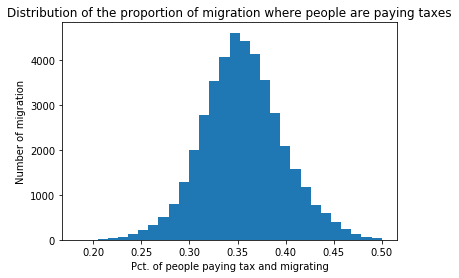

In [48]:
plt.hist(df_node_pct["pct_return"].values, normed=False, bins=30)
plt.title('Distribution of the proportion of migration where people are paying taxes')
plt.ylabel('Number of migration');
plt.xlabel('Pct. of people paying tax and migrating');

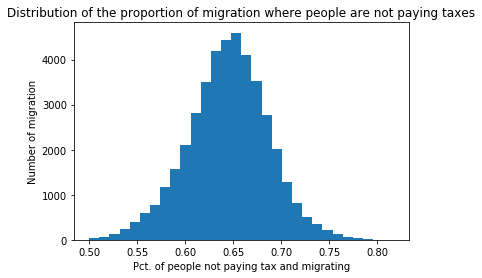

In [49]:
plt.hist(df_node_pct["pct_exempt"].values, normed=False, bins=30)
plt.title('Distribution of the proportion of migration where people are not paying taxes')
plt.ylabel('Number of migration');
plt.xlabel('Pct. of people not paying tax and migrating');

The first observation that can be made is that the distributuon of the proportion of people paying tax / people not paying taxes is Gausian. On average 65% people who migrate are exempted to pay taxes and 35% pay taxes.   
A migration flow is characterized by at most  50% people paying taxes : no migration flow has more people paying taxes then people not paying taxes. This observation will reveal to be usefill when we will build our first connection graph.   
Let's study the the distribution of salary :

In [50]:
# TO DO : Distribution of the salary to study

## I.2 Build our first graphs

The data at hand is interesting because we can build simple graph witout having to use a similarity kernel : one can see the county as the node of our graph and the edges are the migrations between each county. Each edge is weighted by either one of the following feature : `returns`, `exemptions` and `agi`. 
To make the graph meaningful, we stich to each node a label : Democrat (if the Democrat won the county during the last presidential election) and Republican (if the Repubican won the county).  
The adjacency matrix is then build by thresholding each weights. More precisely, we keep only migration that have more than 70% of people not paying taxes, or we keep flows where more than 35% of people are paying taxes. These values were choser to represent the last quartile of each proportion distribution discussed earlier. 
The graph is then saved into a $gexf$ file and studied with the application $Gephi$. 

In [51]:
A_total = np.zeros((num_nodes, num_nodes))
A_returns = np.zeros((num_nodes, num_nodes))
A_exemptions = np.zeros((num_nodes, num_nodes))
for i in range (0, num_flows) : 
    total = mig_flow["returns"][i] + mig_flow["exemptions"][i]
    A_total[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["returns"][i] + mig_flow["exemptions"][i]
    A_returns[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["returns"][i]/total
    A_exemptions[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["exemptions"][i]/total

With these two graphs will try to verify the flowing hypothesis : 
1. **Hypothesis 1** : a migration flow with a more than 35% people paying taxes will have as destination a republican county
2. **Hypothesis 2** : a migration flow with a more than 70% people not paying taxes will have as destination a democrat county

In [52]:
# create adjacency matrix for flows with more then 45% returns 
plot_adj_returns = False 
threshold_returns = 0.45
adjacency_nonRGB_returns = A_returns.copy()
adjacency_nonRGB_returns[adjacency_nonRGB_returns >= threshold_returns] = 1
adjacency_nonRGB_returns[adjacency_nonRGB_returns < threshold_returns] = 0

if plot_adj_returns : 
    plt.spy(adjacency_nonRGB_returns)
    plt.show()

In [53]:
# create adjacency matrix for flows with more then 70% returns 
plot_adj_returns = False 
thershold_exempt = 0.72
adjacency_nonRGB_exempt = A_exemptions.copy()
adjacency_nonRGB_exempt[adjacency_nonRGB_exempt >= thershold_exempt] = 1
adjacency_nonRGB_exempt[adjacency_nonRGB_exempt < thershold_exempt] = 0
if plot_adj_returns : 
    plt.spy(adjacency_nonRGB_exempt)
    plt.show()

In [54]:
# construct graph for flows with more then 45% returns 
graph_nonRGB_returns = nx.from_numpy_array(adjacency_nonRGB_returns)
n = nodes["gop_pct_2016"].values
n[n >= 0.5] = 1
n[n < 0.5] = 0
n_id = nodes["node_id"].values
n_new = np.concatenate(([n_id], [n]),axis=0 )

node = pd.DataFrame(n_new.T, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    nx.set_node_attributes(graph_nonRGB_returns, node_props[key], key)

nx.write_gexf(graph_nonRGB_returns, 'graph_nonRGB_returns.gexf')

In [55]:
# construct graph for flows with more then 780% exemptions 
graph_nonRGB_exempt = nx.from_numpy_array(adjacency_nonRGB_exempt)
n = nodes["gop_pct_2016"].values
n[n >= 0.5] = 1
n[n < 0.5] = 0
n_id = nodes["node_id"].values
n_new = np.concatenate(([n_id], [n]),axis=0 )

node = pd.DataFrame(n_new.T, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    nx.set_node_attributes(graph_nonRGB_exempt, node_props[key], key)

nx.write_gexf(graph_nonRGB_exempt, 'graph_nonRGB_exempt.gexf')

When we plot the graphs and study them with $Gephi$ we can make the following observations : 
1. **Observation 1** : migration flow with a high proportion of `returns` are mainly between Democrat county. There is hardly any high `returns` migration that are coming from Republican county
2. **Observation 2** : migration flow with a high proportion of `exemption` do not have a particular structure. They are especially not going from Republican state to Democrat state.

As a conclusion, the two hypothethis stated before do not hold.   
It appears that migration flow caracterized by a high proportion of `exemption` has no particular structure : they can be between Republican to Democrat county or vice versa, with no particual preference.   
However, the migration flow of high `returns` exhibit a pattern : migration flows with a high proportion of people paying taxes are between Democratic county and there is hardly no high `returns` migration between Republican county. 

So it appears that people who are living in a Republican county and that pay taxes do not move a lot. On the other hand, people who are paying taxes and are living in a Democrat state are more likely to move, and they will certainly move to a Democrat State

# I.3 Build a similarity graph

In [56]:
X = nodes.copy()
X = X.drop(columns=["node_id", "fips_code", "state_code", "state", "pop_09", "pop_12", "median_age_09", "median_age_12", "median_income_09", "median_income_12", "white_nonhisp_pct_10", "white_nonhisp_pct_12", "bach_pct_09", "bach_pct_12", "unemp_pct_09", "unemp_pct_12", "median_hou_09", "median_hou_12", "pop_00", "median_income_00", "white_nonhisp_pct_00", "median_age_00", "bach_pct_00", "median_hou_00", "unemp_pct_00", "gop_pct_2016", "gop_pct_2012", "gop_pct_2008", "gop_pct_2004"])
X_std = StandardScaler().fit_transform(X)

In [57]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """  
    distance=squareform(pdist(X, 'euclidean'))
    print(np.mean(distance))
    weights=np.exp(-distance**2/(2*sigma*sigma))
    np.fill_diagonal(weights,0)
    plt.hist(weights.reshape(weights.shape[0]**2 ,1),bins=100)
    plt.title("distance treshold")
    plt.show()
    adjacency=weights
    adjacency[adjacency<epsilon]=0
    a=np.ones_like(adjacency)
    return adjacency

3.2667882642292287


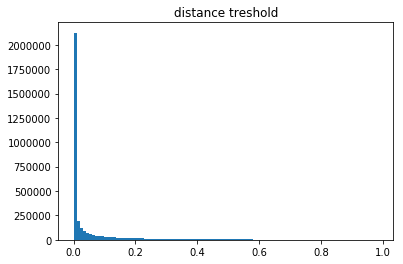

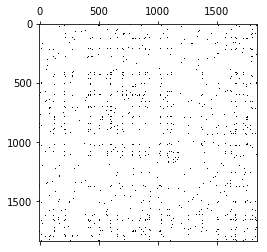

(1838, 1838)


In [58]:
adjacency_RGB = epsilon_similarity_graph(X_std, sigma=3.2667882642292287*0.25, epsilon=0.5)
plt.spy(adjacency_RGB)
plt.show()
print(adjacency_RGB.shape)

In [59]:
graph_RGB = nx.from_numpy_array(adjacency_RGB)
n = nodes["gop_pct_2016"].values
n[n >= 0.5] = 1
n[n < 0.5] = 0
n_id = nodes["node_id"].values
n_new = np.concatenate(([n_id], [n]),axis=0 )

node = pd.DataFrame(n_new.T, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    nx.set_node_attributes(graph_nonRGB_exempt, node_props[key], key)

nx.write_gexf(graph_nonRGB_exempt, 'graph_RGB.gexf')

In [60]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

y_std = n
classes = [0, 1]

# This cell can take a few minutes to run
run_this_cell = False

if run_this_cell:
    # In 2d
    embeddings = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_std)
        fig = plt.figure()
        for i in classes:
            mask = y_std == i
            plt.scatter(X_std[mask, 0], X_std[mask, 1], label=i)
        plt.legend()
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    embeddings = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_std)
        fig = plt.figure()
        ax = Axes3D(fig)
        for i in classes:
            mask = y_std == i
            ax.scatter(X_std[mask, 0], X_std[mask, 1], X_std[mask, 2], label=i)
        ax.legend()
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

### As a conclusion one can see that our the given graph has no similarity structure. We change dataset and try with another one

# II. Second try with IRS dataset

The IRS (i.e Internal Revenue Service) website contains a dataset of all the migrations between county. We can access data about the migration inflow or the migration outflaw of each county. 
We are more interested by the inflow migration dataset which describes what kind of immigration a county was subject to.
The IRS allow us to have access to 3 different type of migration inflow for each county : 
1. People who migrated and that are US citizen 
2. People who migrated and that are not US citizen 
3. The total number of people who migrated

Each of this flow is caracterized by 3 variables : 
1. `returns`: the number of people who moved and payed taxes
2. `exemption`: the number of people who moved and did not pay taxes
3. `agi`: the average salary of the people who moved 

To complete this dataset, we found a dataset that compiles the results of the 2016 Presidential Election by counties. The dataset comes from The Guardian (a British Newspaper). 

## II.1 Extract, clean the data 
First, load the county migration dataset and clean it. 

In [118]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

In [119]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

# keep only summury information of each county
df_migrations = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration")]

# create the combined fips county number 
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# drop useless information 
df_migrations = df_migrations.drop(columns=["y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str"])

# seperate each possible migration into three dataframe 
df_migration_total = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US and Foreign")]
df_migrations['y1_countyname'] = df_migrations['y1_countyname'].apply(lambda x : x if x.find("County Total Migration-US and Foreign") == -1 else "County Total Migration Both")
df_migration_us = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US")]
df_migration_for = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-Foreign")]

# drop the name of the column 
df_migration_total = df_migration_total.drop(columns=["y1_countyname"])
df_migration_us = df_migration_us.drop(columns=["y1_countyname"])
df_migration_for = df_migration_for.drop(columns=["y1_countyname"])

# remove nodes where data is undefined undefined data by zero
df_migration_total = df_migration_total[df_migration_total['n1'] != -1]
df_migration_us = df_migration_us[df_migration_us['n1'] != -1]
df_migration_for = df_migration_for[df_migration_for['n1'] != -1]

# convert combined fips to int64
df_migration_total['combined_fips'] = df_migration_total['combined_fips'].astype('int64')
df_migration_us['combined_fips'] = df_migration_us['combined_fips'].astype('int64')
df_migration_for['combined_fips'] = df_migration_for['combined_fips'].astype('int64')

Second load the 2016 Presidential Election by counties dataset and clean it 

In [120]:
df_presidential_result = pd.read_csv("./NTDS_Data/2016_US_County_Level_Presidential_Results.csv" )
df_presidential_result = df_presidential_result.drop(columns=["Unnamed: 0","votes_dem", "votes_gop", "total_votes", "diff", "per_point_diff", "state_abbr", "county_name"])

Third we merge the two dataset and add a new colmumn called `winner` that is defined as follow : if the Republican had a majority in the county, then `winner` equals 1. Otherwise, the Democrat won a majority in the county and `winner` equals 0.

In [121]:
# merge the two dataset and drop useless column, add a new column winner 
df_merged_total = pd.merge(df_migration_total, df_presidential_result, on="combined_fips", how='inner')
df_merged_us = pd.merge(df_migration_us, df_presidential_result, on="combined_fips", how='inner')
df_merged_for = pd.merge(df_migration_for, df_presidential_result, on="combined_fips", how='inner')
df_merged_total['difference'] = df_merged_total['per_dem'] - df_merged_total['per_gop']
df_merged_us['difference'] = df_merged_us['per_dem'] - df_merged_total['per_gop']
df_merged_for['difference'] = df_merged_for['per_dem'] - df_merged_total['per_gop']
df_merged_total['winner'] = df_merged_total['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_us['winner'] = df_merged_us['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_for['winner'] = df_merged_for['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_total = df_merged_total.drop(columns=['difference'])
df_merged_us = df_merged_us.drop(columns=['difference'])
df_merged_for = df_merged_for.drop(columns=['difference'])

Finally, we upload data about the number of people living in a county. 

In [122]:
""""
df_pop = pd.read_csv("./NTDS_Data/PopulationEstimates.csv")
df_pop = df_pop[["FIPS", "POP_ESTIMATE_2016"]]
df_pop.columns = ["combined_fips", "POP_ESTIMATE_2016"]
df_merged_for = pd.merge(df_merged_for, df_pop, on="combined_fips", how='inner')
df_merged_for["n3"] = df_merged_for["n1"] + df_merged_for["n2"]
df_merged_for["POP_ESTIMATE_2016"] = df_merged_for["POP_ESTIMATE_2016"].apply(lambda x : int(x.replace(',', '')))
#df_merged_for = df_merged_for.to_numeric(axis=["POP_ESTIMATE_2016"])

df_merged_for["n3"] = df_merged_for["n3"].divide(df_merged_for["POP_ESTIMATE_2016"].astype(int))
"""

'"\ndf_pop = pd.read_csv("./NTDS_Data/PopulationEstimates.csv")\ndf_pop = df_pop[["FIPS", "POP_ESTIMATE_2016"]]\ndf_pop.columns = ["combined_fips", "POP_ESTIMATE_2016"]\ndf_merged_for = pd.merge(df_merged_for, df_pop, on="combined_fips", how=\'inner\')\ndf_merged_for["n3"] = df_merged_for["n1"] + df_merged_for["n2"]\ndf_merged_for["POP_ESTIMATE_2016"] = df_merged_for["POP_ESTIMATE_2016"].apply(lambda x : int(x.replace(\',\', \'\')))\n#df_merged_for = df_merged_for.to_numeric(axis=["POP_ESTIMATE_2016"])\n\ndf_merged_for["n3"] = df_merged_for["n3"].divide(df_merged_for["POP_ESTIMATE_2016"].astype(int))\n'

## II.2 Build the graph

From each cells you get two attributes : adjency matrix and the nodes with its associated signal (called winner)

**The similarity graph for total migration**
 - adjency matrix : `adjacency_RGB_total`
 - nodes : `nodes_total`

0.5284353963018223


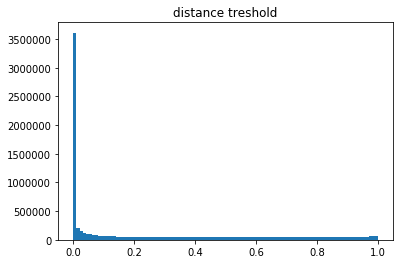

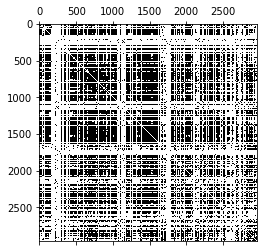

In [123]:
X_total = df_merged_total.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_total = df_merged_total.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_total['agi'] = (X_total['agi'] - X_total['agi'].mean()) / X_total['agi'].std()
X_total['prop_ret/exempt'] = X_total['n1'] / X_total['n2']
X_total = X_total.drop(columns=['n1', 'n2'])
adjacency_RGB_total = epsilon_similarity_graph(X_total, sigma=0.5284353963018223*0.1, epsilon=0.3)
plt.spy(adjacency_RGB_total)
plt.show()

**The similarity graph for foreigner migration only**
 - adjency matrix : `adjacency_RGB_for`
 - nodes : `nodes_for`

0.6675252605174871


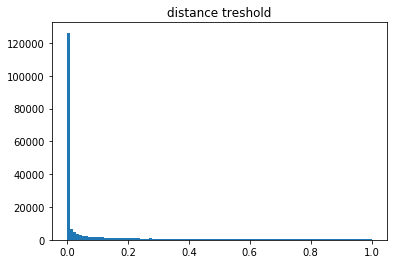

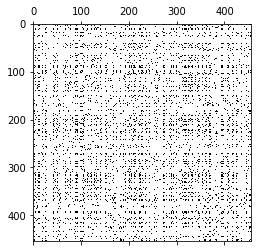

In [124]:
X_for = df_merged_for.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_for = df_merged_for.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_for['agi'] = (X_for['agi'] - X_for['agi'].mean()) / X_for['agi'].std()
X_for['prop_ret/exempt'] = X_for['n1'] / X_for['n2']
X_for = X_for.drop(columns=['n1', 'n2'])
adjacency_RGB_for = epsilon_similarity_graph(X_for, sigma=0.6675252605174871*0.1, epsilon=0.5)
plt.spy(adjacency_RGB_for)
plt.show()

**The similarity graph for US citizen migration only**
 - adjency matrix : `adjacency_RGB_us`
 - nodes : `nodes_us`

0.5310405705207334


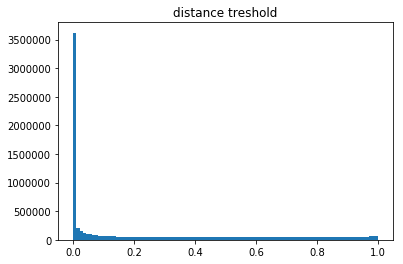

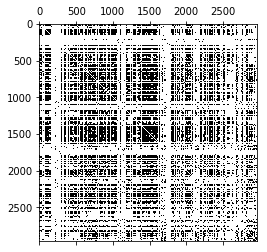

In [125]:
X_us = df_merged_us.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_us = df_merged_us.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_us['agi'] = (X_us['agi'] - X_us['agi'].mean()) / X_us['agi'].std()
X_us['prop_ret/exempt'] = X_us['n1'] / X_us['n2']
X_us = X_us.drop(columns=['n1', 'n2'])
adjacency_RGB_us = epsilon_similarity_graph(X_us, sigma=0.5310405705207334*0.1, epsilon=0.5)
plt.spy(adjacency_RGB_us)
plt.show()

In [126]:
n = df_merged_total['winner'].values

In [ ]:
X_us = df_merged_us.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner']).values
nodes_us = df_merged_us.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_us_std = StandardScaler().fit_transform(X_us)
adjacency_RGB_us = epsilon_similarity_graph(X_us_std, sigma=0.976934499862608*0.1, epsilon=0.2)
plt.spy(adjacency_RGB_us)
plt.show()
print(adjacency_RGB_us.shape)

In [ ]:
X_for = df_merged_for.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner']).values
nodes_for = df_merged_for.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_for_std = StandardScaler().fit_transform(X_for)
X_for_std.shape
adjacency_RGB_for = epsilon_similarity_graph(X_for_std, sigma=0.7946351372390517*0.25m, epsilon=0.4)
plt.spy(adjacency_RGB_for)
plt.show()
print(adjacency_RGB_for.shape)

In [ ]:
graph_RGB_total = nx.from_numpy_array(adjacency_RGB_for)
node = pd.DataFrame(nodes_total, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    nx.set_node_attributes(graph_RGB_total, node_props[key], key)

nx.write_gexf(graph_RGB_total, 'graph_RGB_total.gexf')

In [ ]:
graph_RGB_us = nx.from_numpy_array(adjacency_RGB_us)
node = pd.DataFrame(nodes_us, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    nx.set_node_attributes(graph_RGB_us, node_props[key], key)

nx.write_gexf(graph_RGB_us, 'graph_RGB_us.gexf')

In [ ]:
graph_RGB_for = nx.from_numpy_array(adjacency_RGB_for)
node = pd.DataFrame(nodes_for, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    nx.set_node_attributes(graph_RGB_for, node_props[key], key)

nx.write_gexf(graph_RGB_for, 'graph_RGB_for.gexf')

# III. Xiaoyan's Mess

In [221]:
A_total = np.zeros((num_nodes, num_nodes))
A_returns = np.zeros((num_nodes, num_nodes))
A_exemptions = np.zeros((num_nodes, num_nodes))
for i in range (0, num_flows) : 
    total = mig_flow["returns"][i] + mig_flow["exemptions"][i]
    A_total[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["returns"][i] + mig_flow["exemptions"][i]
    A_returns[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["returns"][i]/total
    A_exemptions[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["exemptions"][i]/total

In [178]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """  
    distance=squareform(pdist(X, 'euclidean'))
    print(np.mean(distance))
    weights=np.exp(-distance**2/(2*sigma*sigma))
    np.fill_diagonal(weights,0)
    plt.hist(weights.reshape(weights.shape[0]**2 ,1),bins=100)
    plt.title("distance treshold")
    plt.show()
    adjacency=weights
    adjacency[adjacency<epsilon]=0
    a=np.ones_like(adjacency)
    return adjacency

## Build graph for returns

2.05213148790842


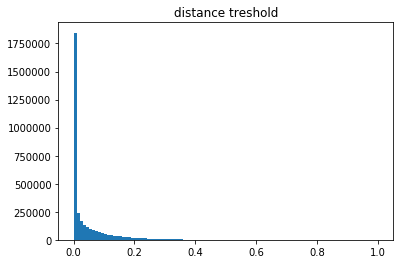

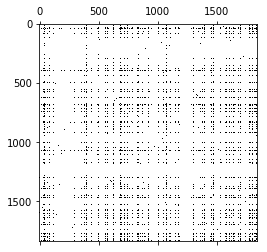

(1838, 1838)


In [218]:
adjacency = epsilon_similarity_graph(A_returns, sigma=2.05*0.25, epsilon=0.2)
plt.spy(adjacency)
plt.show()
print(adjacency.shape)

In [219]:
graph = nx.from_numpy_array(adjacency)
n = nodes["gop_pct_2016"].values
n[n >= 0.5] = 1
n[n < 0.5] = 0
n_id = nodes["node_id"].values
n_new = np.concatenate(([n_id], [n]),axis=0 )

node = pd.DataFrame(n_new.T, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    # print(key, node_props[key])
    nx.set_node_attributes(graph, node_props[key], key)

nx.write_gexf(graph, 'test2.gexf')

In [220]:
#nx.draw_spectral(graph, with_labels=True)
nx.write_gexf(graph, 'test2.gexf')

In [46]:
list0 = node[node["result"]==0]
list1 = node[node["result"]==1]

In [38]:
node_props["id"][0]

1.0

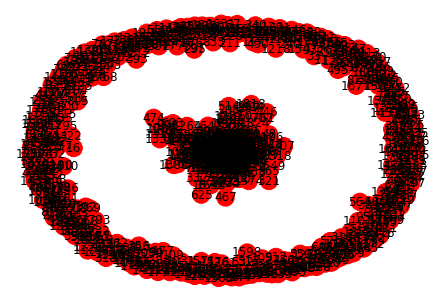

In [48]:
color_map = []
for node in graph:
    if node in list0:
        #print(node)
        color_map.append('blue') # <0.5
    else: 
        print("red :",node)
        color_map.append('red')  # >=0.5    
nx.draw(graph,node_color = color_map,with_labels = True)
plt.show()

/home/xzou/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/xzou/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


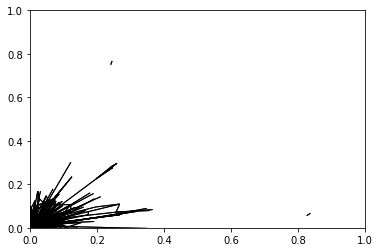

In [29]:
pos=nx.spring_layout(graph)
nx.draw_networkx_edges(graph,pos,with_labels=True,
                       nodelist=list0,
                       node_color='r')
nx.draw_networkx_edges(graph,pos,with_labels=True,
                       nodelist=list1,
                       node_color='b')

In [ ]:
#draw_networkx_edges

## Build graph for exemptions

3.7416357141025385


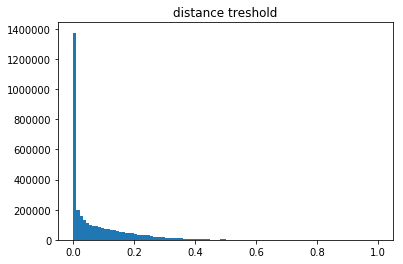

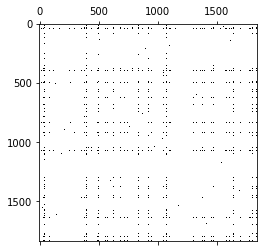

(1838, 1838)


In [200]:
adjacency_exempt = epsilon_similarity_graph(A_exemptions, sigma=3.74*0.3, epsilon=0.4)
plt.spy(adjacency_exempt)
plt.show()
print(adjacency_exempt.shape)

In [201]:
graph_exempt = nx.from_numpy_array(adjacency_exempt)
n = nodes["gop_pct_2016"].values
n[n >= 0.5] = 1
n[n < 0.5] = 0
n_id = nodes["node_id"].values
n_new = np.concatenate(([n_id], [n]),axis=0 )

node = pd.DataFrame(n_new.T, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    # print(key, node_props[key])
    nx.set_node_attributes(graph_exempt, node_props[key], key)

In [202]:
nx.write_gexf(graph_exempt, 'result_exempt.gexf')

In [207]:
np.count_nonzero(n)/n.shape[0]

0.7377584330794341

# Graph without RGB kernel

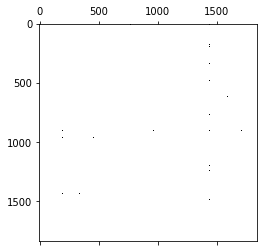

In [279]:
threshold_returns = 0.45
adjacency_nonRGB_returns = A_returns.copy()
adjacency_nonRGB_returns[adjacency_nonRGB_returns >= threshold_returns] = 1
adjacency_nonRGB_returns[adjacency_nonRGB_returns < threshold_returns] = 0
plt.spy(adjacency_nonRGB_returns)
plt.show()

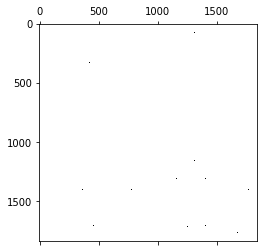

In [284]:
thershold_exempt = 0.72
adjacency_nonRGB_exempt = A_exemptions.copy()
adjacency_nonRGB_exempt[adjacency_nonRGB_exempt >= thershold_exempt] = 1
adjacency_nonRGB_exempt[adjacency_nonRGB_exempt < thershold_exempt] = 0
plt.spy(adjacency_nonRGB_exempt)
plt.show()

In [281]:
graph_nonRGB_returns = nx.from_numpy_array(adjacency_nonRGB_returns)
n = nodes["gop_pct_2016"].values
n[n >= 0.5] = 1
n[n < 0.5] = 0
n_id = nodes["node_id"].values
n_new = np.concatenate(([n_id], [n]),axis=0 )

node = pd.DataFrame(n_new.T, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    nx.set_node_attributes(graph_nonRGB_returns, node_props[key], key)

nx.write_gexf(graph_nonRGB_returns, 'graph_nonRGB_returns.gexf')

In [285]:
graph_nonRGB_exempt = nx.from_numpy_array(adjacency_nonRGB_exempt)
n = nodes["gop_pct_2016"].values
n[n >= 0.5] = 1
n[n < 0.5] = 0
n_id = nodes["node_id"].values
n_new = np.concatenate(([n_id], [n]),axis=0 )

node = pd.DataFrame(n_new.T, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    nx.set_node_attributes(graph_nonRGB_exempt, node_props[key], key)

nx.write_gexf(graph_nonRGB_exempt, 'graph_nonRGB_exempt.gexf')